<a href="https://colab.research.google.com/github/yongtaoliu/HZO_conductivespots/blob/main/HZO_ConductiveSpots_AE.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **3DFeM Project: HZO conductive spots automated experiment**

March, 2022

- Work lead by [Sergei V. Kalinin](https://scholar.google.com/citations?hl=en&user=-cuxoSQAAAAJ&view_op=list_works&sortby=pubdate)
- Workflow by [Yongtao Liu](https://scholar.google.com/citations?user=V9FMPgQAAAAJ&hl=en) 
- Hf0.54Zr0.48O2 film by Shelby S. Fields, Takanori Mimura, Jon F. Ihlefeld


# **Install**

In [1]:
!pip install --upgrade imutils
!pip install opencv-python

# **Import**

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import time
import os
import imutils

# **Download and Load Data**

*   Here we use the data in our manuscript to show the workflow
*   In an experiment, here the data should be an in-situ image data



In [3]:
!gdown https://drive.google.com/uc?id=1llRkntZB8t1yuQrYbBW2KJ50oRnGBW2v

Downloading...
From: https://drive.google.com/uc?id=1llRkntZB8t1yuQrYbBW2KJ50oRnGBW2v
To: /content/data_HZO_AE.zip
100% 148k/148k [00:00<00:00, 77.9MB/s]


In [4]:
! unzip -q data_HZO_AE.zip

replace data_HZO_AE/BaseImage_DC6d7V_size05V_30.npy? [y]es, [n]o, [A]ll, [N]one, [r]ename: A


In [5]:
path = "/content/data_HZO_AE/"
os.chdir(path)

In [6]:
#load data
#the current-voltage amplifier is 10e7, so convert the data to nA by multiplying 100
DC6d7 = np.load('BaseImage_DC6d7V_size05V_30.npy')*100

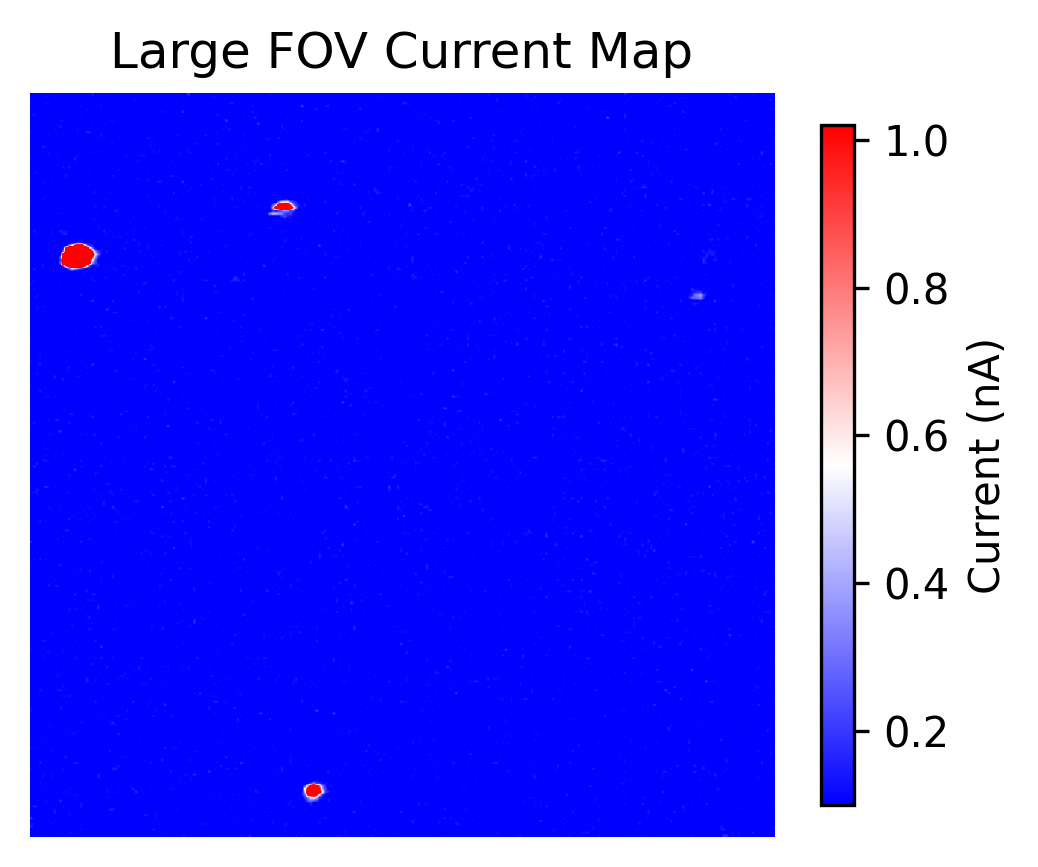

In [7]:
#plot current map
f, ax = plt.subplots(figsize = (4,4), dpi = 300)
plt.imshow(DC6d7, vmin = 0.1, vmax = 1.02, cmap = 'bwr', origin = 'lower')
plt.title("Large FOV Current Map")
plt.axis ("off")
plt.colorbar(shrink = 0.75, label = "Current (nA)")

# **Feature-Discovery Step**


*   In feature-discovery step, we first use a thresholding value to convert the image to binary. (i) the thresholding value can be customized according to the image in processing, or (ii) can be determined from the the histogram plot of the processing image. 


*   In addition to using threshold filter, we note that users can also use other filter, e.g. median filter, depending on the specific problem. 




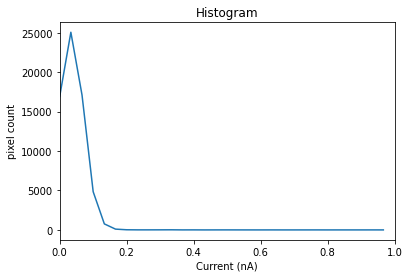

In [8]:
# show the histogram of the cAFM image
histogram, bin_edges = np.histogram(DC6d7, bins=30, range=(0.0, 1.0))
fig, ax = plt.subplots()
plt.plot(bin_edges[0:-1], histogram)
plt.title("Histogram")
plt.xlabel("Current (nA)")
plt.ylabel("pixel count")
plt.xlim(0, 1.0)
plt.show()

In [9]:
start_time = time.time()

In [10]:
#detect hotspots by applying a threshold filter
thresh = np.copy(DC6d7)
th = 0.18
thresh[DC6d7 > th] = 1
thresh[DC6d7 <= th] = 0

*   Then, we find the minimum circles that can contain the features (these features are conductive spots in this work) in the binary image, in doing so, we can get the features sizes (circle radius) and the features locations (circle center).
*   Below we provide two approaches to remove the small spots which are most likely measurement noise. First is directly removing the spots with radius < 2pixels from the list; second is applying a median filter to the hotspots image.

Approach 1. Remove small radius spots

In [11]:
# find contours in the thresholded image
thresh = thresh.astype(np.uint8)

cnts = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

center = np.zeros((len(cnts), 2))
radius = np.zeros(len(cnts))
for i in range (len(cnts)):
    (x,y),r = cv2.minEnclosingCircle(cnts[i])
    #center location
    center[i,0] = x
    center[i,1] = y
    #radius of minimum circle
    radius[i] = r

In [12]:
#delete small spots as they are most likely measurement noise
ms = 2
center = np.delete(center, np.where(radius < ms), axis = 0)
radius = np.delete(radius, np.where(radius < ms), axis = 0)

*   Next, the zoom-in scan regions are determined according to the feature locaitons and the zoom-in scan sizes are determined according to the features sizes. In this work, the zoom-in scan sizes are feature_size*4 (as we think this scan size allows us to visulize the expansion (if there is an expansion) of the conductive spots). However, we note that users can customize the scan size and other parameters.

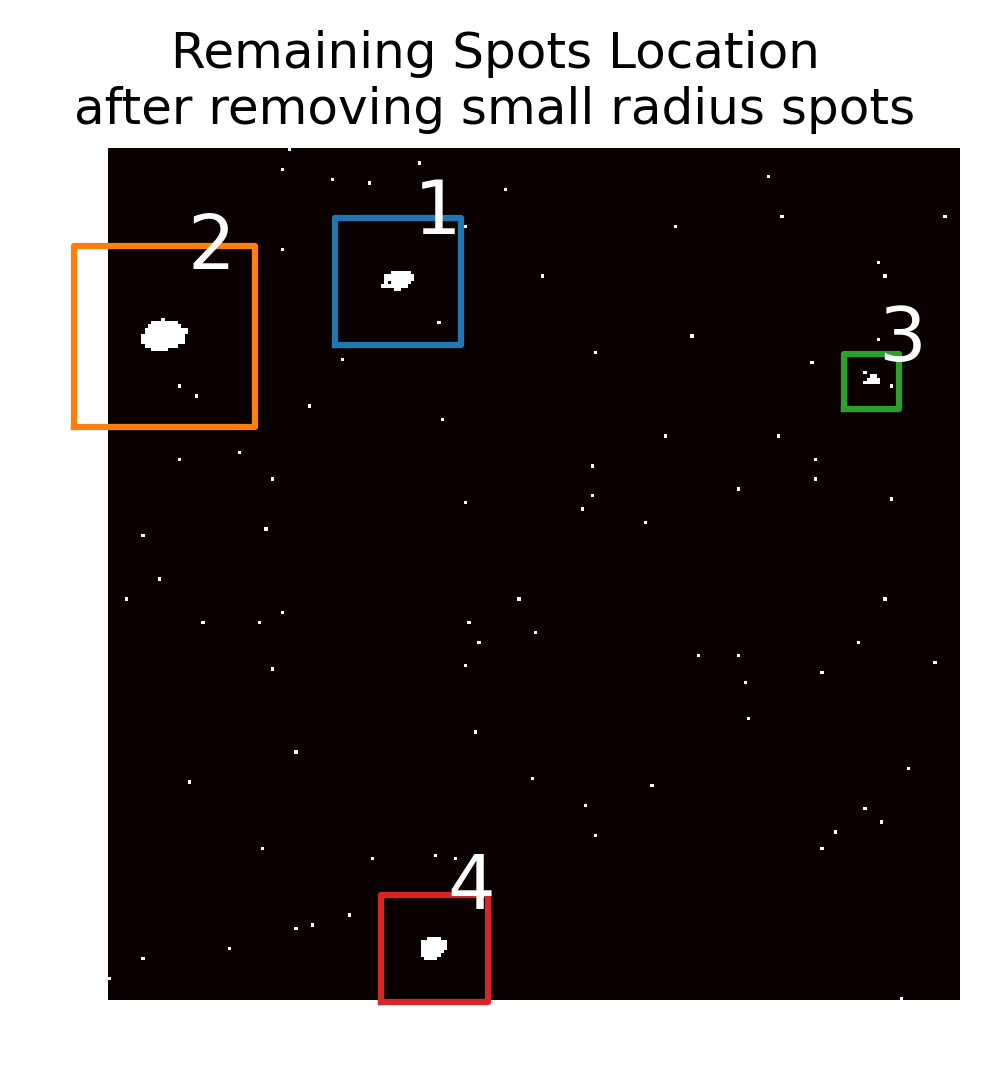

In [13]:
#plot zoom-in measurement areas
boxs = np.zeros((len(radius),2,5))
rad = radius*4

for i in range (len(radius)):
    boxs[i,0,] = center[i,0]-rad[i], center[i,0]-rad[i], center[i,0]+rad[i], center[i,0]+rad[i],center[i,0]-rad[i]
    boxs[i,1,] = center[i,1]-rad[i], center[i,1]+rad[i], center[i,1]+rad[i], center[i,1]-rad[i],center[i,1]-rad[i]

f, ax = plt.subplots(figsize = (4,4), dpi = 300)
plt.imshow(thresh, vmin = 0, vmax = 0.8, cmap = 'hot', origin = 'lower')
plt.title("Remaining Spots Location\nafter removing small radius spots")
plt.axis ("off")

for i in range (len(radius)):
    x = center[i,0]; y = center[i,1]
    r = rad[i]
    plt.plot(boxs[i,0,], boxs[i,1,])
    plt.text(x+r/4, y+3*r/4, str(i+1), c = 'white', fontsize = 18)

In [14]:
print ("feature detection time: ")
print(time.time()-start_time)

feature detection time: 
0.41165709495544434


Approach 2. Apply a median filter to the spots image

In [15]:
from skimage.filters import median
from skimage.morphology import disk 

In [16]:
medfil_image = median(thresh, disk(1))

In [17]:
cnts = cv2.findContours(medfil_image, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)

center = np.zeros((len(cnts), 2))
radius = np.zeros(len(cnts))
for i in range (len(cnts)):
    (x,y),r = cv2.minEnclosingCircle(cnts[i])
    #center location
    center[i,0] = x
    center[i,1] = y
    #radius of minimum circle
    radius[i] = r

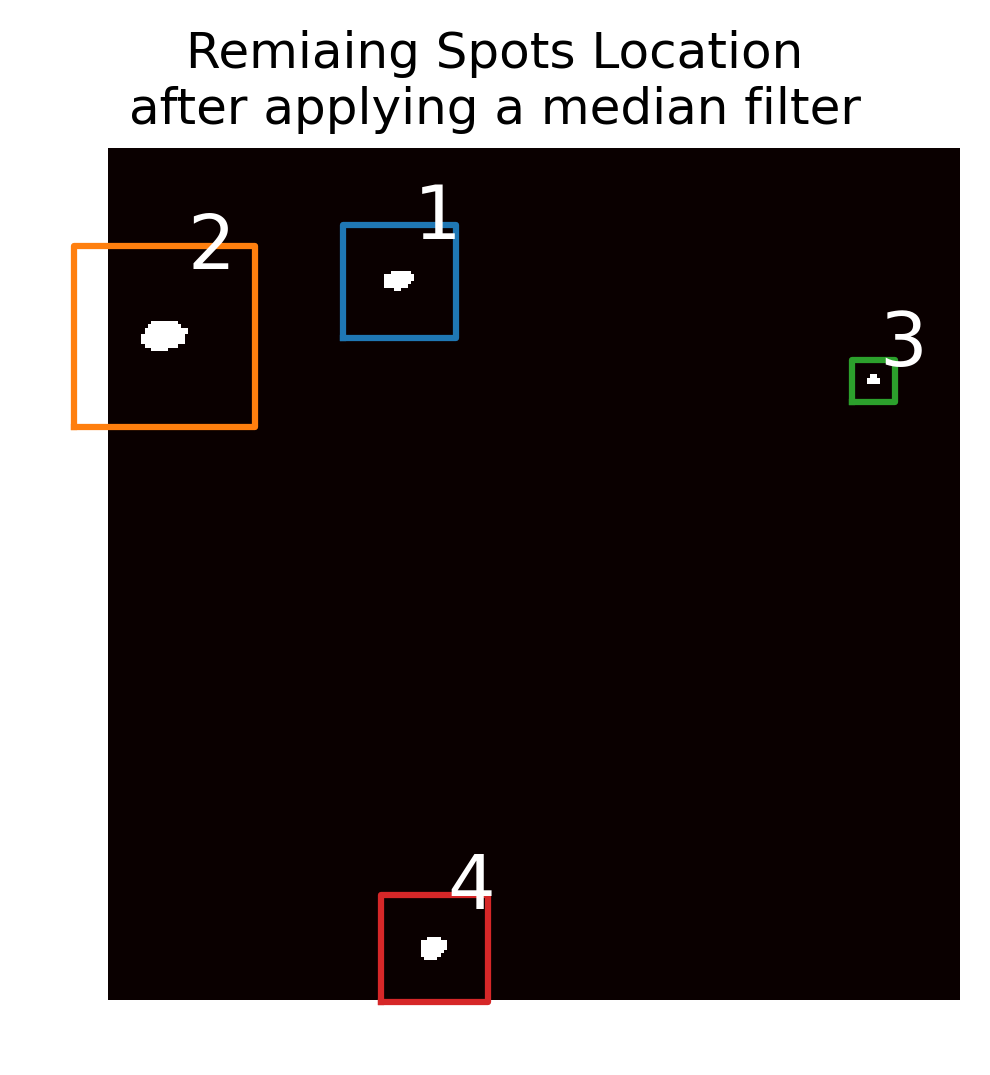

In [18]:
#plot zoom-in measurement areas
boxs = np.zeros((len(radius),2,5))
rad = radius*4

for i in range (len(radius)):
    boxs[i,0,] = center[i,0]-rad[i], center[i,0]-rad[i], center[i,0]+rad[i], center[i,0]+rad[i],center[i,0]-rad[i]
    boxs[i,1,] = center[i,1]-rad[i], center[i,1]+rad[i], center[i,1]+rad[i], center[i,1]-rad[i],center[i,1]-rad[i]

f, ax = plt.subplots(figsize = (4,4), dpi = 300)
plt.imshow(medfil_image, vmin = 0, vmax = 0.8, cmap = 'hot', origin = 'lower')
plt.title("Remiaing Spots Location\nafter applying a median filter")
plt.axis ("off")

for i in range (len(radius)):
    x = center[i,0]; y = center[i,1]
    r = rad[i]
    plt.plot(boxs[i,0,], boxs[i,1,])
    plt.text(x+r/4, y+3*r/4, str(i+1), c = 'white', fontsize = 18)

*   Finally, we need to convert these values (e.g. scan size and location) to the AFM measurement parameters. In this work, we use an Oxford Instrument Asylum Cypher AFM system, we can control AFM scan with customized Piezo-X and Piezo-Y in this system. So that we convert these values to the Piezo values that matching the scan parameters in the Asylum Cypher system; then we use an FPGA to generate Piezo voltages and subsequently send them to the Piezo channels of the Asylum Cypher AFM. 